<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/Test_code/Preprocessing_and_Binning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# Ensure your dataset has a "depth" column along with "longitude" and "latitude"
# If not, you'll need to add it before running the following code.

# Example: Load your data (adjust the path as needed)
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')

# For demonstration, let's assume you also have a 'depth' column
# If depth is not available, you'll need to include it or compute it from other information
if 'depth' not in df.columns:
    raise ValueError("The DataFrame must contain a 'depth' column for voxel binning.")

# Define the number of bins for each dimension (adjust as needed)
num_lon_bins = 100
num_lat_bins = 100
num_depth_bins = 100

# Compute bin edges using np.linspace based on the min and max of each variable
lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num_lon_bins + 1)
lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num_lat_bins + 1)
depth_bins = np.linspace(df['depth'].min(), df['depth'].max(), num_depth_bins + 1)

# Create new columns that assign each row to a bin index (0-based)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=False, include_lowest=True)

# Create a voxel identifier as a tuple of (lon_bin, lat_bin, depth_bin)
df['voxel'] = list(zip(df['lon_bin'], df['lat_bin'], df['depth_bin']))

# Group the data by voxel and compute aggregate statistics, e.g., mean oxygen value
voxel_grouped = df.groupby('voxel').agg({
    'oxygen': 'mean',
    'longitude': 'mean',
    'latitude': 'mean',
    'depth': 'mean'
}).reset_index()

print("Binned Data (first few voxels):")
print(voxel_grouped.head())


Binned Data (first few voxels):
        voxel      oxygen  longitude   latitude      depth
0  (0, 27, 0)  270.406067 -64.402184  47.650585   1.316770
1  (0, 27, 1)  273.270905 -64.400017  47.648060   5.223880
2  (0, 27, 2)  275.757233 -64.399178  47.647827   8.740151
3  (0, 27, 3)  276.677216 -64.399002  47.647758  12.315401
4  (0, 27, 4)  277.740356 -64.399078  47.647751  15.866035


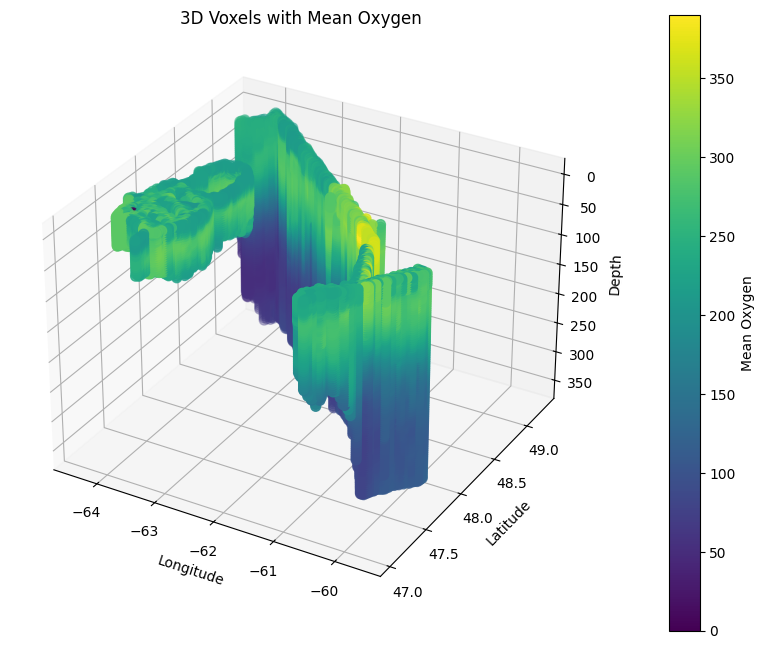

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Assuming you have 'voxel_grouped' DataFrame from the previous binning code

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: x=longitude, y=latitude, z=depth, colored by mean oxygen
sc = ax.scatter(voxel_grouped['longitude'], voxel_grouped['latitude'],
                voxel_grouped['depth'], c=voxel_grouped['oxygen'], cmap='viridis', s=50)

# Add color bar to indicate oxygen levels
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Mean Oxygen')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth")
ax.set_title("3D Voxels with Mean Oxygen")

# Optionally, if depth is measured as a positive value going downward, you might want to invert the z-axis
ax.invert_zaxis()

plt.show()


In [ ]:
# Install dependencies if needed (uncomment if required)
#!pip install pykrige statsmodels scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pykrige.ok import OrdinaryKriging
import statsmodels.api as sm

#############################################
# STEP 1: Load Raw Data and Split into Train/Test
#############################################
# Load the raw data (ensure it has 'longitude', 'latitude', 'depth', 'oxygen' and other predictor columns)
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')


# Ensure coordinates are floats
df[['longitude', 'latitude']] = df[['longitude', 'latitude']].astype(np.float64)

# Check required columns exist
required_cols = ['longitude', 'latitude', 'depth', 'oxygen']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Define predictor columns as all columns except time, longitude, latitude, depth, and oxygen
exclude_cols = ['time', 'longitude', 'latitude', 'depth', 'oxygen']
predictor_cols = [col for col in df.columns if col not in exclude_cols]

print("Predictor columns:", predictor_cols)

# Split raw data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Raw data split: {len(train_df)} training samples, {len(test_df)} testing samples.")

#############################################
# STEP 2: Bin (Aggregate) the Training Data into Voxels
#############################################
# Define number of bins for each spatial dimension (adjust as needed)
num_lon_bins = 10
num_lat_bins = 10
num_depth_bins = 10

# Create bin edges based on training data ranges
lon_bins = np.linspace(train_df['longitude'].min(), train_df['longitude'].max(), num_lon_bins+1)
lat_bins = np.linspace(train_df['latitude'].min(), train_df['latitude'].max(), num_lat_bins+1)
depth_bins = np.linspace(train_df['depth'].min(), train_df['depth'].max(), num_depth_bins+1)

# Assign each training sample to a bin (0-indexed)
train_df['lon_bin'] = pd.cut(train_df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
train_df['lat_bin'] = pd.cut(train_df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
train_df['depth_bin'] = pd.cut(train_df['depth'], bins=depth_bins, labels=False, include_lowest=True)

# Create a voxel identifier as a tuple (lon_bin, lat_bin, depth_bin)
train_df['voxel'] = list(zip(train_df['lon_bin'], train_df['lat_bin'], train_df['depth_bin']))

# Group by voxel and compute mean values for oxygen, coordinates, and all predictors
agg_dict = {'oxygen': 'mean', 'longitude': 'mean', 'latitude': 'mean', 'depth': 'mean'}
for col in predictor_cols:
    agg_dict[col] = 'mean'

voxel_grouped = train_df.groupby('voxel').agg(agg_dict).reset_index()
print("Sample aggregated (voxel) training data:")
print(voxel_grouped.head())

#############################################
# STEP 3: Train a Regression Model Using All Predictors on Aggregated Training Data
#############################################
# Define the response and predictor variables for regression
# We use the aggregated oxygen as the response
y_train_agg = voxel_grouped['oxygen'].values
# Use all aggregated predictor columns from voxel_grouped.
# (We exclude the spatial coordinates because they will be used in kriging.)
X_train_agg = voxel_grouped[[col for col in voxel_grouped.columns if col in predictor_cols]].values

# Add a constant for the intercept term
X_train_agg_const = sm.add_constant(X_train_agg)

# Fit an OLS regression model
ols_model = sm.OLS(y_train_agg, X_train_agg_const).fit()
print(ols_model.summary())

# Compute regression predictions on the aggregated training data and residuals
y_train_pred_reg = ols_model.predict(X_train_agg_const)
residuals_train = y_train_agg - y_train_pred_reg

#############################################
# STEP 4: Fit a Kriging Model on the Aggregated Training Residuals
#############################################
# We use the voxel centers (mean longitude and latitude) as coordinates for kriging.
coords_train_agg = voxel_grouped[['longitude', 'latitude']].values

# Fit Ordinary Kriging on residuals (using spherical variogram)
OK = OrdinaryKriging(
    coords_train_agg[:,0],
    coords_train_agg[:,1],
    residuals_train,
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)
# (No need to execute prediction here; we just fit the model on aggregated training residuals.)

#############################################
# STEP 5: Predict on Raw Test Data Using Regression + Kriging Correction
#############################################
# --- Regression Prediction ---
# For each raw test observation, we use all predictors to get a regression prediction.
# Ensure that the test data has the same predictor columns.
X_test_raw = test_df[predictor_cols].values
X_test_raw_const = sm.add_constant(X_test_raw)
y_test_pred_reg = ols_model.predict(X_test_raw_const)

# --- Kriging Correction ---
# Use the raw test coordinates (longitude, latitude) to predict a residual correction.
coords_test_raw = test_df[['longitude', 'latitude']].values
kriged_residuals, _ = OK.execute('points', coords_test_raw[:,0], coords_test_raw[:,1])

# Final prediction = regression prediction + kriged residual correction
y_test_pred_final = y_test_pred_reg + kriged_residuals

#############################################
# STEP 6: Evaluate Model Performance on Raw Test Data
#############################################
y_test_true = test_df['oxygen'].values
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred_final))
mae_test = mean_absolute_error(y_test_true, y_test_pred_final)
r2_test = r2_score(y_test_true, y_test_pred_final)

print("\n--- Regression-Kriging (with all predictors) Performance on Raw Test Data ---")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")
print(f"R²:   {r2_test:.4f}")

#############################################
# STEP 7: Visualize Predictions vs Actual on Raw Test Data
#############################################
plt.figure(figsize=(6,5))
plt.scatter(y_test_true, y_test_pred_final, alpha=0.7, edgecolor='k')
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')
plt.xlabel("Actual Oxygen (Test)")
plt.ylabel("Predicted Oxygen (Test)")
plt.title("Regression-Kriging (All Predictors) on Raw Test Data")
plt.show()


Predictor columns: ['temperature', 'salinity', 'density']
Raw data split: 8285479 training samples, 2071370 testing samples.
Sample aggregated (voxel) training data:
       voxel      oxygen  longitude   latitude      depth  temperature  \
0  (0, 1, 0)  277.695648 -64.109275  47.416260  17.637426     6.207549   
1  (0, 1, 1)  285.164246 -64.145106  47.423932  41.414845     2.579501   
2  (0, 2, 0)  257.024475 -64.087905  47.599925  17.022764     9.617033   
3  (0, 2, 1)  264.129517 -64.113933  47.619648  47.955173     1.543534   
4  (0, 2, 2)  237.423462 -64.063018  47.659618  73.143913     0.780017   

    salinity      density  
0  29.480291  1023.141602  
1  30.458286  1024.487183  
2  28.609955  1021.983032  
3  31.092354  1025.097412  
4  31.814854  1025.850342  
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:        